# Generative Adversarial Networks for Image Generation


In this notebook, we will implement a basic Generative Adversarial Network (GAN) for image generation and lay the groundwork for applying GANs to time series data. 

The goal is twofold: first, to gain hands-on experience with the core components of a GAN using a well-known example, generating images from the MNIST dataset. Second, to develop a flexible `GanModule` that can be reused in later notebooks for time series generation.

This reusable module will make it easy to experiment with different generator and discriminator architectures, enabling you to test custom designs in a modular way.


## Import libraries

In [1]:
import torchvision
from torchvision.transforms import ToTensor 
from sklearn.model_selection import train_test_split
import torch
from genai4t.utils import set_random_state
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from genai4t.plot_style import plot_style

In [2]:
# Environment configuration
ENV_CONFIG = {
    "random_state": 2024 # Seed for reproducibility across runs
}

# Data configuration for loading the MNIST dataset
DATA_CONFIG = {
    "data_dir": "'./artifacts/MNIST", # Directory where the MNIST dataset will be stored
    "batch_size": 64                  # Batch size used during training
}

## Loading and Preparing the Data

The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database is a classic dataset of handwritten digits, consisting of grayscale images sized 28×28 pixels, with digits ranging from 0 to 9. The dataset includes 60,000 training images and 10,000 test images, and is widely used for benchmarking both image classification and generative modeling tasks. Below we download the dataset from `torchvision`


In [3]:
# Load the MNIST dataset from torchvision
# The transform `ToTensor()` converts PIL images to torch.Tensor
# and normalizes pixel values from the range [0, 255] (uint8) to [0.0, 1.0] (float32)
dataset = torchvision.datasets.MNIST(
    root=DATA_CONFIG["data_dir"], download=True,
    transform=ToTensor())

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:16<00:00, 609kB/s]


Extracting './artifacts/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to './artifacts/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 316kB/s]


Extracting './artifacts/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to './artifacts/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:05<00:00, 328kB/s]


Extracting './artifacts/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to './artifacts/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.10MB/s]

Extracting './artifacts/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to './artifacts/MNIST/MNIST/raw



In [4]:
# Split the dataset into training and test sets (80/20 split)
# This includes both images and their corresponding digit class labels
train_xy_dataset, test_xy_dataset = train_test_split(
    dataset,
    test_size=0.2,
    random_state=ENV_CONFIG["random_state"])

In [5]:
# Preview a sample from the training dataset
image, y_class = train_xy_dataset[0]

In [6]:
# Check the shape of the image tensor
image.shape

torch.Size([1, 28, 28])

In [7]:
y_class

2

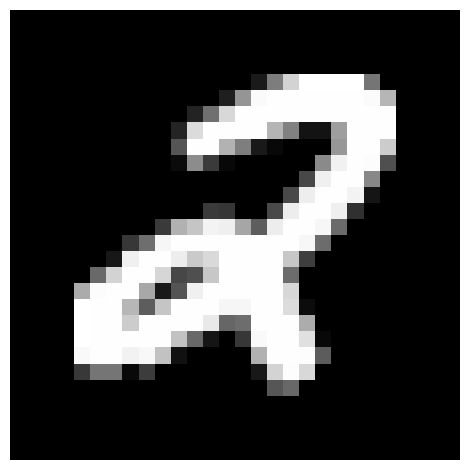

In [8]:
# Display the image using matplotlib
# Convert the tensor to NumPy format and use grayscale colormap
f, ax = plt.subplots()
ax.imshow(image.numpy()[0], cmap="gray")
ax.axis('off')
plot_style.apply_plot_style(ax)
plt.show()

In [9]:
# Remove class labels since we're doing unconditional image generation
# Only keep the image tensors (x) and discard the labels (_)
train_ds = [x for x, _ in train_xy_dataset]
test_ds = [x for x, _ in test_xy_dataset]

In [10]:
# Create the training dataloader
# This enables batching and shuffling for training
train_dl = DataLoader(
    train_ds,
    batch_size=DATA_CONFIG['batch_size'],
    shuffle=True)

In [11]:
# Create the test dataloader (no shuffling needed for evaluation)
test_dl = DataLoader(
    test_ds,
    batch_size=DATA_CONFIG['batch_size'])

In [12]:
# Get a batch of training images
batch = next(iter(train_dl))
# Check the shape of the batch:
batch.shape

torch.Size([64, 1, 28, 28])

## GANs

[Generative Adversarial Networks (GANs)](https://arxiv.org/abs/1406.2661), by Goodfellow et al., 2014,  are a prominent class of implicit generative models, known for their ability to generate high-quality, realistic, high-dimensional samples. Unlike explicit models, GANs do not attempt to estimate a probability density function directly; instead, they focus on learning how to sample high quality data. 


Training a GAN involves learning two models:

- The Generator $G$, which takes as input a random vector $z$ from a latent space (typically, a realized value sampled from a standard normal distribution) and produces synthetic data.
- The Discriminator $D$, which receives either real data (from the training set) or fake data (from the generator), and learns to classify whether the input is real or generated.


The core idea behind GAN training is an adversarial game between these two models:

- The discriminator is trained to distinguish real data from fake data, optimizing its parameters to become better at binary classification.
- The generator is trained to fool the discriminator, improving its ability to generate data that the discriminator cannot distinguish from real samples.


To train the discriminator, we construct a dataset with:

- Real samples, such as digits from the MNIST dataset, labeled with 1.
- Fake samples, generated by sampling from a randomly initialized generator $G$,  labeled with 0.

With this dataset of real and fake samples, the discriminator is trained as a standard binary classifier. Then, using the loss signal provided by the discriminator, we train the generator to improve its output. This process is repeated iteratively.


A practical question that often arises is: How many fake samples should we generate per iteration?
In most implementations, the number of fake samples is set equal to the number of real samples in each training batch. This makes sure the discriminator is trained on a balanced binary classification task. We will follow this approach in the implementation below.

In summary, GAN training is a two-player game:

- The discriminator learns to distinguish real from fake.
- The generator learns to fool the discriminator into classifying fake data as real.

This adversarial setup is formalized through what is commonly referred to as the **adversarial loss**.

More information about GANs can be found in Chapter 8 of the book, with additional details available in [Generative Adversarial Networks (GANs)](https://arxiv.org/abs/1406.2661)




### Loss Function


To train the discriminator, we minimize the negative log-likelihood of correctly classifying both real and fake samples.


$$
\mathcal{L}_D = - \sum_t \log D(x_t) - \sum_{t'} \log{(1 - D(G(z_{t'}))}
$$

To train the generator, we minimize the loss below, that encourage $G(z)$ to be classified as real.

$$
\mathcal{L}_G = - \sum_{t'} \log(D(G(z_{t'}))
$$


*Note*: This version of the generator loss is known as the non-saturating loss, introduced in the original GAN paper by Goodfellow et al., (2014) as a practical alternative to the minimax formulation. It also provides a stronger gradient signal during the early stages of training. For more details on the min-max formulation, see Chapter 8.



### Implementation: `GanModule`

In the implementation that follows, we define a flexible GanModule using PyTorch Lightning, which includes:

- A Generator – maps latent vectors to samples in the original data space.
- A Discriminator – outputs the probability that a given input is real.
- A Sampler – generates latent vectors from a known prior distribution (e.g., standard Gaussian).

This implementation is inspired by the following [lightning tutorial](https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/basic-gan.html).

In [ ]:
from torch import nn
import torch
from lightning.pytorch.utilities import grad_norm
import abc
from typing import Tuple
from genai4t.model.utils import SampleTimeSeries
from genai4t.model.core import BaseLightningModule


class GanStepManager():
    """Manages the training schedule between generator and discriminator.
    
    This class controls when to train the generator vs discriminator based on the current step
    and configured parameters. It supports a warmup period for the discriminator before
    starting generator training.
    
    Attributes:
        discriminator_steps (int): Number of steps to train discriminator per cycle
        generator_steps (int): Number of steps to train generator per cycle
        discriminator_warmup (int): Number of initial steps to train only discriminator
    """
    
    def __init__(
        self,
        discriminator_steps: int,
        generator_steps: int,
        discriminator_warmup: int):
        self._step = -discriminator_warmup
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.total_steps = discriminator_steps + generator_steps
        self.train_discriminator = True

    @property 
    def train_generator(self) -> bool:
        """Determine if generator should be trained at current step.
        
        Returns:
            bool: True if generator should be trained, False otherwise
        """
        return self._step >= 0 and (0 <= self._step % self.total_steps < self.generator_steps)

    def step(self) -> None:
        """Advance the training step counter."""
        self._step += 1


class BaseGanModule(BaseLightningModule):
    """Base class for GAN implementations.
    
    This abstract base class provides the core functionality for GAN training,
    including step management and training loop structure. Concrete implementations
    must implement the step() method to define the specific GAN architecture.
    
    Attributes:
        lr (float): Learning rate for optimizers
        weight_decay (float): Weight decay for optimizers
        discriminator_steps (int): Number of discriminator steps per cycle
        generator_steps (int): Number of generator steps per cycle
        discriminator_warmup (int): Number of warmup steps for discriminator
    """
    
    def __init__(self,
        lr: float = 1e-3,
        weight_decay: float = 0.,
        discriminator_steps: int = 5,
        generator_steps: int = 5,
        discriminator_warmup: int = 50,
        ):
        """Initialize the base GAN module.
        
        Args:
            lr: Learning rate for optimizers
            weight_decay: Weight decay for optimizers
            discriminator_steps: Number of discriminator steps per cycle
            generator_steps: Number of generator steps per cycle
            discriminator_warmup: Number of warmup steps for discriminator
        """
        super().__init__(
            lr=lr,
            weight_decay=weight_decay
            )
    
        self.automatic_optimization = False
        self.step_manager = GanStepManager(
            discriminator_steps=discriminator_steps,
            generator_steps=generator_steps,
            discriminator_warmup=discriminator_warmup,
        )

    @abc.abstractmethod
    def step(
        self,
        batch: torch.Tensor,
        train_generator: bool,
        train_discriminator: bool) -> Tuple[torch.Tensor, torch.Tensor]:
        """Perform a single training step.
        
        Args:
            batch: Input batch of real data
            train_generator: Whether to train the generator
            train_discriminator: Whether to train the discriminator
            
        Returns:
            Tuple containing generator loss and discriminator loss
        """
        raise NotImplementedError
    

    def training_step(self, batch, batch_idx) -> None:
        """Perform a training step.
        
        Args:
            batch: Input batch of real data
            batch_idx: Index of the current batch
        """
        train_generator = self.step_manager.train_generator
        train_discriminator: bool = not train_generator
        assert train_generator or train_discriminator
        assert not (train_generator and train_discriminator)

        generator_loss, discriminator_loss = self.step(
            batch,
            train_generator=train_generator,
            train_discriminator=train_discriminator
            )

        if generator_loss is not None:
            self.log('generator_loss', generator_loss.item(), on_step=True, on_epoch=False, prog_bar=True)
        if discriminator_loss is not None:
            self.log('discriminator_loss', discriminator_loss.item(), on_step=True, on_epoch=False, prog_bar=True)

        self.step_manager.step()
    
    def validation_step(self, batch, batch_idx) -> None:
        """Perform a validation step.
        
        Args:
            batch: Input batch of real data
            batch_idx: Index of the current batch
        """
        raise NotImplementedError


class GanModule(BaseGanModule):
    """Standard GAN implementation with generator and discriminator.
    
    This class implements a standard GAN architecture with alternating training
    between generator and discriminator. It uses binary cross entropy loss and
    supports gradient clipping.
    
    Attributes:
        generator (nn.Module): Generator network
        discriminator (nn.Module): Discriminator network
        sampler (SampleTimeSeries): Sampler for generating latent vectors
        lr (float): Learning rate for optimizers
        weight_decay (float): Weight decay for optimizers
        discriminator_steps (int): Number of discriminator steps per cycle
        generator_steps (int): Number of generator steps per cycle
        discriminator_warmup (int): Number of warmup steps for discriminator
        betas (Tuple[float, float]): Beta parameters for Adam optimizer
        clip_gradient_norm (float): Maximum gradient norm for clipping
        log_norm (bool): Whether to log gradient norms
    """
    
    def __init__(
        self,
        generator: nn.Module, 
        discriminator: nn.Module,
        sampler: SampleTimeSeries,
        lr: float = 1e-3,
        weight_decay: float = 0.,
        discriminator_steps: int = 5,
        generator_steps: int = 5,
        discriminator_warmup: int = 50,
        betas: Tuple[float, float] = (0.5, 0.999),
        clip_gradient_norm: float = None,
        log_norm: bool = False,
        ):
        """Initialize the GAN module.
        
        Args:
            generator: Generator network
            discriminator: Discriminator network
            sampler: Sampler for generating latent vectors
            lr: Learning rate for optimizers
            weight_decay: Weight decay for optimizers
            discriminator_steps: Number of discriminator steps per cycle
            generator_steps: Number of generator steps per cycle
            discriminator_warmup: Number of warmup steps for discriminator
            betas: Beta parameters for Adam optimizer
            clip_gradient_norm: Maximum gradient norm for clipping
            log_norm: Whether to log gradient norms
        """
        super().__init__(
            lr=lr,
            weight_decay=weight_decay,
            discriminator_steps=discriminator_steps,
            generator_steps=generator_steps,
            discriminator_warmup=discriminator_warmup,
        )
        self.generator = generator
        self.discriminator = discriminator
        self.sampler = sampler
        self._bce_loss = nn.BCEWithLogitsLoss()
        self.betas = betas
        self.clip_gradient_norm = clip_gradient_norm
        self.log_norm = log_norm

    
    def configure_optimizers(self):
        """Configure optimizers for generator and discriminator.
        
        Returns:
            List of optimizers and empty list of schedulers
        """
        generator_opt = torch.optim.Adam(
            self.generator.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay,
            betas=self.betas,
            )

        discriminator_opt = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay,
            betas=self.betas,
            )

        return [generator_opt, discriminator_opt], []


    def discriminator_step(
        self,
        x: torch.Tensor,
        z: torch.Tensor,
        discriminator_opt: torch.optim.Optimizer) -> torch.Tensor:
        """Perform a single discriminator training step.
        
        Args:
            x: Real data batch
            z: Latent vectors for generator
            discriminator_opt: Discriminator optimizer
            
        Returns:
            Discriminator loss
        """
        self.toggle_optimizer(discriminator_opt)
        try:
            x_fake = self.generator(z)
        
            y_fake = self.discriminator(x_fake)
            y_real = self.discriminator(x)

            d_real_loss = self._bce_loss(y_real, torch.ones_like(y_real))
            d_fake_loss = self._bce_loss(y_fake, torch.zeros_like(y_fake))
            d_loss = (d_real_loss + d_fake_loss) / 2

            discriminator_opt.zero_grad()
            self.manual_backward(d_loss)
            
            if isinstance(self.clip_gradient_norm, float):
                self.clip_gradients(discriminator_opt, self.clip_gradient_norm, gradient_clip_algorithm='norm')

            if self.log_norm:
                norms = grad_norm(self, norm_type=2)
                norms['gen_step'] = 0
                self.log_dict(norms)

            discriminator_opt.step()
        finally:
            self.untoggle_optimizer(discriminator_opt)

        return d_loss
       

    def generator_step(
        self,
        z: torch.Tensor,
        generator_opt: torch.optim.Optimizer) -> torch.Tensor:
        """Perform a single generator training step.
        
        Args:
            z: Latent vectors for generator
            generator_opt: Generator optimizer
            
        Returns:
            Generator loss
        """
        self.toggle_optimizer(generator_opt)
        try:
            x_fake = self.generator(z)
            y_fake = self.discriminator(x_fake)
                
            generator_loss = self._bce_loss(y_fake, torch.ones_like(y_fake))

            # zero grad
            generator_opt.zero_grad()
            self.manual_backward(generator_loss)

             # clip gradients
            if isinstance(self.clip_gradient_norm, float):
                self.clip_gradients(generator_opt, self.clip_gradient_norm, gradient_clip_algorithm='norm')
            
            if self.log_norm:
                norms = grad_norm(self, norm_type=2)
                norms['gen_step'] = 0
                self.log_dict(norms)

            # update parameters
            generator_opt.step()
        finally:
            # untoggle
            self.untoggle_optimizer(generator_opt)

        return generator_loss

    def step(
        self,
        x: torch.Tensor,
        train_discriminator: bool = True,
        train_generator: bool = True
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Perform a single training step for both generator and discriminator.
        
        Args:
            x: Real data batch
            train_discriminator: Whether to train discriminator
            train_generator: Whether to train generator
            
        Returns:
            Tuple containing generator loss and discriminator loss
        """
        self.zero_grad()
        generator_opt, discriminator_opt = self.optimizers()
        z = self.sampler.sample(x.size(0)).to(x.device)

        discriminator_loss = generator_loss = None
        if train_generator:
            generator_loss = self.generator_step(z=z, generator_opt=generator_opt)

        if train_discriminator:
            discriminator_loss = self.discriminator_step(x=x, z=z, discriminator_opt=discriminator_opt)
        return generator_loss, discriminator_loss


We use the `GanModule` as a flexible wrapper to train any GAN model by injecting custom generator and discriminator networks. To make this reusable across different implementations, we've refactored the module into `genai4t.chapters.gans`.

This allows us to easily import `GanModule` in future notebooks or projects, streamlining the setup process for training GANs.

In [14]:
from genai4t.chapters.gans import GanModule

###  GANs Discriminator and Generator

Since we are working with image data, we’ll use convolutional neural networks (CNNs) for both the generator and the discriminator.


#### Generator

The generator takes a random noise vector from the latent space (of size `latent_dim`) and transforms it into a `28×28` grayscale image, the same size as the images in the MNIST dataset. This is done using a series of transposed convolutional layers (also known as deconvolutions). 

A final Sigmoid activation is applied to ensure that the output pixel values lie in the $[0, 1]$ range, matching the normalized format of the MNIST dataset.


#### Discriminator

The discriminator receives a `28×28` grayscale image, either real or generated, and outputs a single scalar value representing the probability that the input is real (i.e., sampled from the dataset). It uses a standard CNN architecture composed of regular convolutional layers to extract features and downsample the image.

*Note*: We do not apply a Sigmoid activation at the end of the discriminator, since the BCEWithLogitsLoss function (used during training) internally applies the sigmoid operation for improved numerical stability.

Below, you will find the corresponding implementations.

In [15]:
import torch
import torch.nn as nn
from typing import Tuple

class MNISTDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)
        )        

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:    
        x = self.encoder(x)
        return x


class MNISTGenerator(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.decoder_input = nn.Linear(latent_dim, 128 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=7, padding=3),  # 28x28 -> 28x28
            nn.Sigmoid()  # Output in range [0, 1] for pixel values
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        bs = z.size(0)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 7, 7)  # Reshape to (batch_size, channels, height, width)
        x = self.decoder(z)
        return x 

    
    
class SampleMnist(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

    def sample(self, bs: int):
        z = torch.randn(bs, self.latent_dim)
        return z

In [16]:
# Import the utility function for training models
# This function handles training loops,
from genai4t.model.utils import fit_model

In [17]:
MODEL_CONFIG = {
    "input_dim": 784, # Flattened size of a 28x28 image (28 * 28)
    "latent_dim": 26, # Dimensionality of the latent (noise) vector
    "lr": 1e-3,  # # Learning rate for both generator and discriminator
    "num_steps": 10 * len(train_dl), # Total number of training steps 
    "model_dir": "./artifacts/MNIST_GANS_2D", # Directory to save model 
    "clip_gradient_norm": 0.5, # Gradient clipping 
}

In [18]:
# Initialize the sampler for the GAN
# This sampler generates latent noise vectors of dimension `latent_dim`
sampler = SampleMnist(MODEL_CONFIG["latent_dim"])

In [19]:
# Initialize the generator and discriminator models for MNIST image generation
# The generator maps noise vectors to 28x28 grayscale images
# The discriminator classifies images as real or fake
generator = MNISTGenerator(MODEL_CONFIG["latent_dim"])
discriminator = MNISTDiscriminator()

In [20]:
generator

MNISTGenerator(
  (decoder_input): Linear(in_features=26, out_features=6272, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): Sigmoid()
  )
)

In [21]:
discriminator

MNISTDiscriminator(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=6272, out_features=1, bias=True)
  )
)

In [22]:
gan = GanModule(
    generator=generator,
    discriminator=discriminator,
    sampler=sampler,
    lr=MODEL_CONFIG["lr"],
    clip_gradient_norm=MODEL_CONFIG["clip_gradient_norm"],
    log_norm=True)

## Train 

In [23]:
# Instantiate the GAN module 
fit_model(
    MODEL_CONFIG["model_dir"],
    gan,
    train_dl,
    num_steps=MODEL_CONFIG["num_steps"],
    random_state=ENV_CONFIG['random_state'],
    plot=False
)

Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | generator     | MNISTGenerator     | 263 K  | train
1 | discriminator | MNISTDiscriminator | 98.9 K | train
2 | sampler       | SampleMnist        | 0      | train
3 | _bce_loss     | BCEWithLogitsLoss  | 0      | train
-------------------------------------------------------------
362 K     Trainable params
0         Non-trainable params
362 K     Total params
1.44

total_n_params: 362114


/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=7500` reached.


### Training progress

Since we now have two separate loss functions, one for the generator and one for the discriminator, we can’t use the same utility functions used in other notebooks to plot a single loss value. For this reason, we will generate the loss plots manually.

In [24]:
# Read training metrics logged from the csv file
metrics = pd.read_csv(f"{MODEL_CONFIG['model_dir']}/lightning_logs/version_0/metrics.csv")

In [25]:
metrics.head()

,discriminator_loss,epoch,gen_step,generator_loss,grad_2.0_norm/discriminator.encoder.0.bias,grad_2.0_norm/discriminator.encoder.0.weight,grad_2.0_norm/discriminator.encoder.3.bias,grad_2.0_norm/discriminator.encoder.3.weight,grad_2.0_norm/discriminator.encoder.6.bias,grad_2.0_norm/discriminator.encoder.6.weight,...,grad_2.0_norm/generator.decoder.0.bias,grad_2.0_norm/generator.decoder.0.weight,grad_2.0_norm/generator.decoder.2.bias,grad_2.0_norm/generator.decoder.2.weight,grad_2.0_norm/generator.decoder.4.bias,grad_2.0_norm/generator.decoder.4.weight,grad_2.0_norm/generator.decoder_input.bias,grad_2.0_norm/generator.decoder_input.weight,grad_2.0_norm_total,step
0,0.000048,0,0.0,NaN,0.000363,0.000324,0.000185,0.000859,0.000022,0.000307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001357,49
1,0.000071,0,0.0,8.544374,0.000957,0.000038,0.000547,0.001201,0.000232,0.000635,...,0.006297,0.003356,0.006477,0.005933,0.002647,0.022267,0.002587,0.002800,0.002317,99
2,0.000117,0,0.0,8.195404,0.002567,0.001497,0.001393,0.003906,0.000420,0.001679,...,0.032138,0.047143,0.432690,0.014050,0.173763,0.163983,0.026241,0.039418,0.006611,149
3,0.609645,0,0.0,0.172478,0.159590,0.151643,0.065326,0.239905,0.039870,0.095004,...,0.008954,0.082905,0.029203,0.074273,0.019263,0.442962,0.060985,0.190712,0.500000,199
4,0.255382,0,0.0,0.442291,0.130606,0.209648,0.069237,0.353519,0.039686,0.092387,...,0.005519,0.113751,0.005227,0.044965,0.002400,0.365243,0.088493,0.306173,0.500000,249


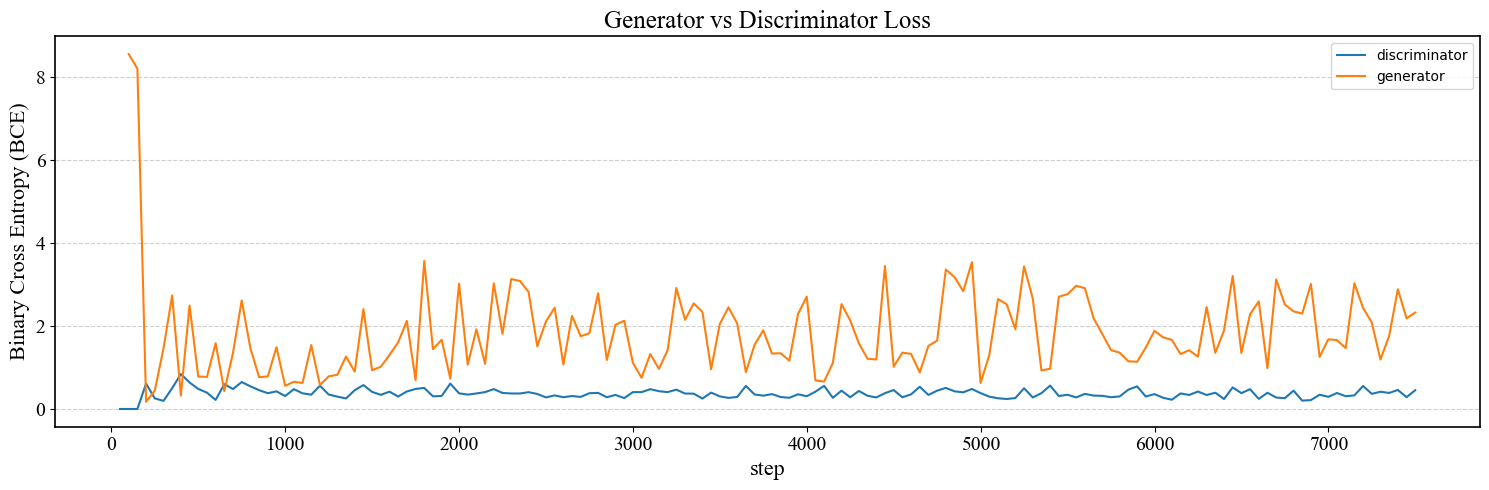

In [26]:
_, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x='step', y='discriminator_loss', data=metrics, label='discriminator')
sns.lineplot(x='step', y='generator_loss', data=metrics, label='generator')
ax.set_ylabel('Binary Cross Entropy (BCE)')
ax.set_title("Generator vs Discriminator Loss")
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax)
ax.legend()
plt.show()

## Generation
Now it is time to generate new images!

###  Unconditional Image Generation
We sample latent vectors from a standard normal distribution, $z \sim \mathcal{N}(\mathbf{0}, I)$, and pass them through the generator to produce new synthetic images.



In [27]:
# Function to plot a grid of generated images
def plot_generations(
    title: str,
    generations: torch.Tensor,
):
    generations = generations.numpy().reshape(-1, 28, 28)
    nrows = generations.shape[0] // 5
    f, axs = plt.subplots(nrows, 5, figsize=(20, 15))
    f.suptitle(title, fontsize=32)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(generations[i], cmap="gray")
        ax.axis('off')
        plot_style.apply_plot_style(ax)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
    plt.show()

In [28]:
# Sample 10 latent vectors from the prior distribution using the sampler
z = sampler.sample(10)
# Generate new images from the latent vectors using the generator
with torch.no_grad():
    generations = generator(z).cpu().view(-1, 28, 28)

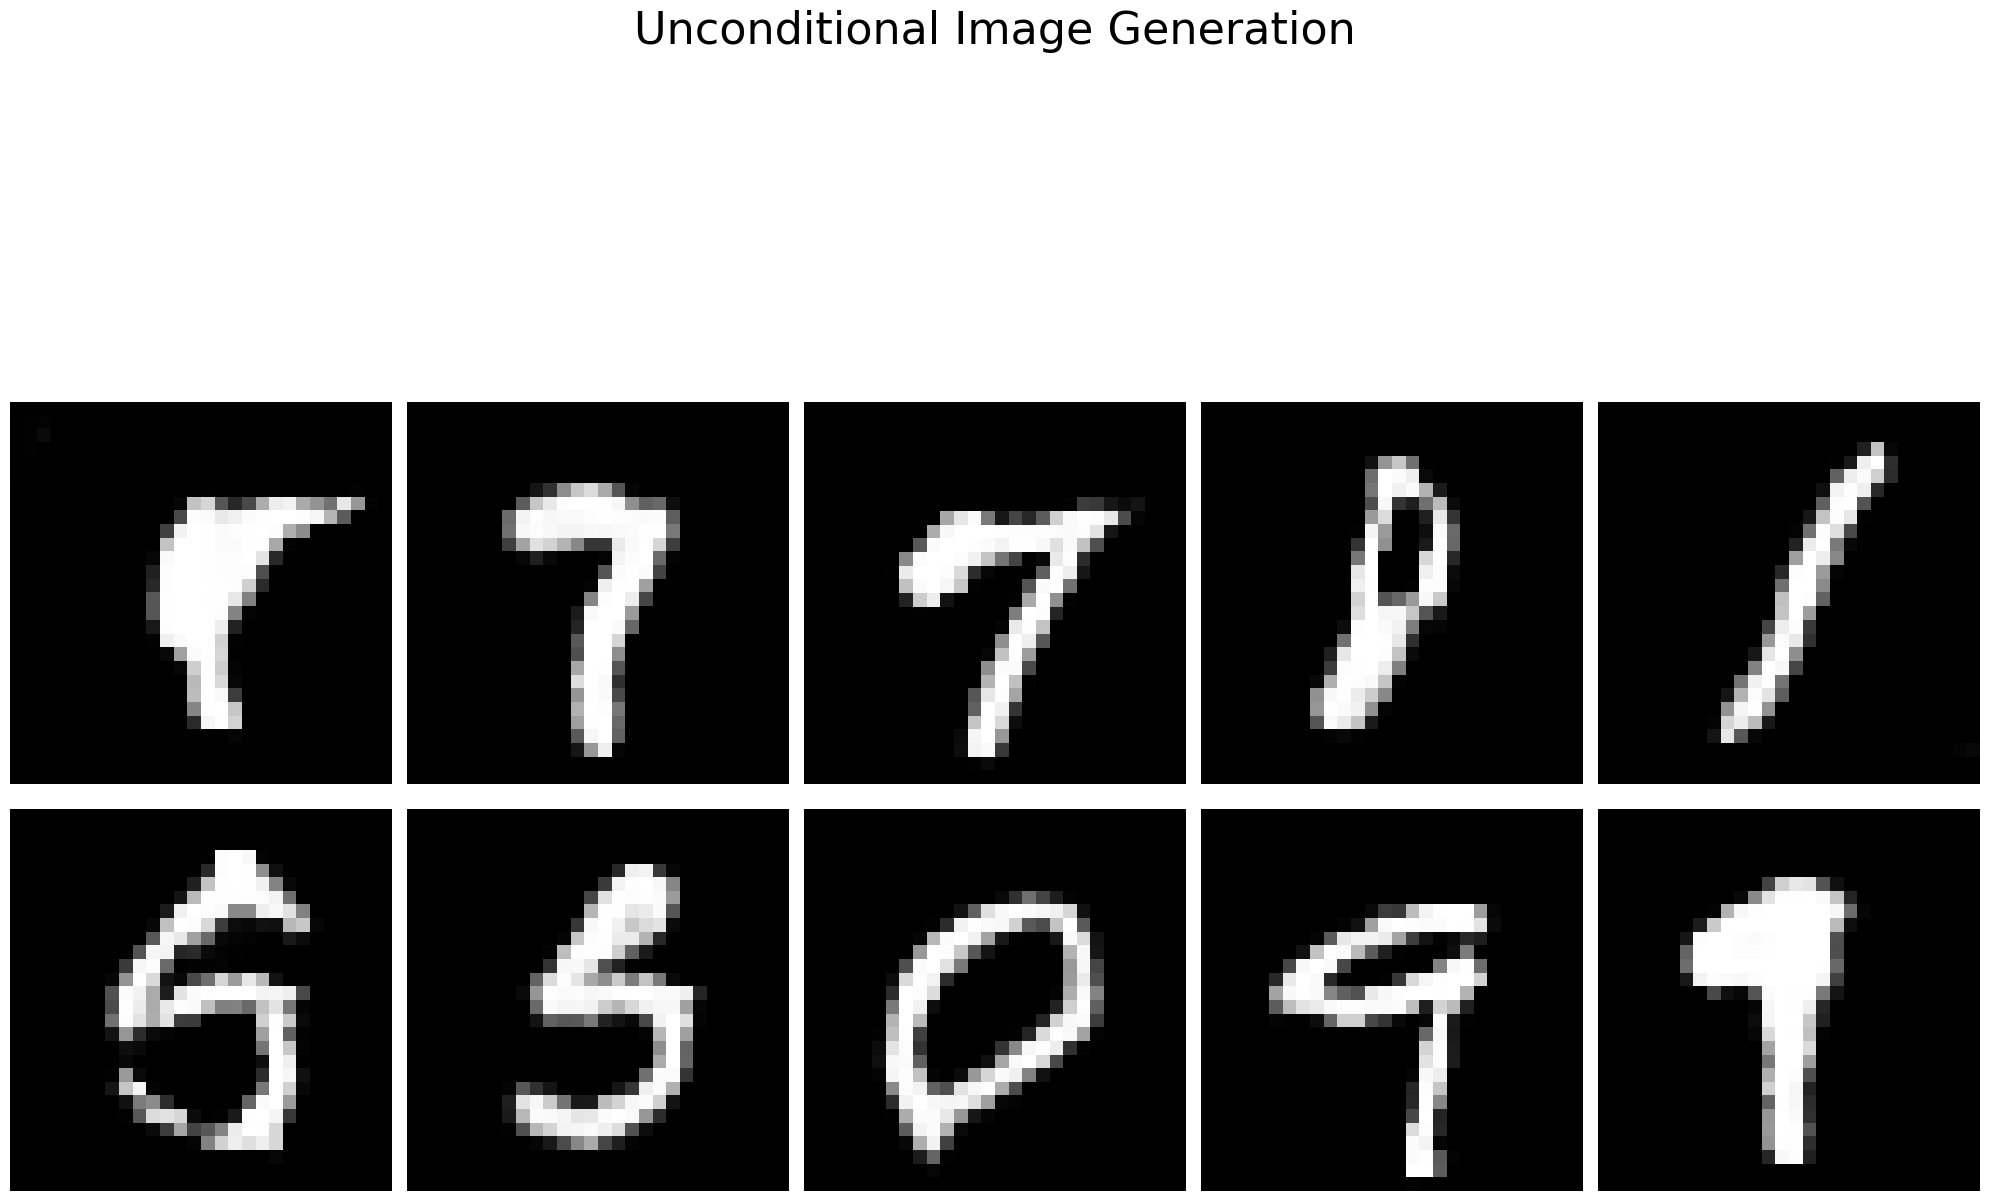

In [29]:
# Plot the generated images
plot_generations("Unconditional Image Generation", generations)